# Prepare unlabeled data

In this notebook, we will prepare the unlabeled data for the data labeling task.

We will also remove some incomplete tweets from the dataset.

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [2]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [3]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.settings import AppSettings
from src.checker import CommentChecker
from src.s3 import Bucket
from sklearn.model_selection import train_test_split
from typing import List

%matplotlib inline

sns.set_theme(style="whitegrid", palette="pastel")

seed = 1993

args = AppSettings()

bucket = Bucket(args.AWS_S3_BUCKET)

bucket.get_session_from_aksk(
    args.AWS_ACCESS_KEY_ID,
    args.AWS_SECRET_ACCESS_KEY
)

In [4]:
def get_origin_plot(origins: List[str]):
    data_plt = {}

    for origin in origins:
        if origin not in data_plt:
            data_plt[origin] = 1
        else:
            data_plt[origin] += 1

    plt.figure(figsize=(8, 4))
    
    # creating the bar plot
    ax = plt.bar(
        list(data_plt.keys()),
        list(data_plt.values()),
        width=0.4)
    
    # adding the labels
    for rect in ax:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, height, ha="center", va="bottom")

    plt.xlabel("Origins")
    plt.ylabel("Texts")
    plt.title("Texts by Origin")
    plt.show()

### 2021-09-24.json

In [5]:
data1 = bucket.download_json(key="raw/2021-09-24.json")

print(f"Total of {len(data1)} comments.")
data1[0]

Total of 515 comments.


{'data': {'text': '🍕🥤🌃👍🏻',
  'ref_id': 1440041127843827721,
  'meta_info': {'source': 'Twitter',
   'created_at': '2021-09-20T19:52:14',
   'collected_at': '2021-09-24T09:42:24.093081',
   'is_toxic': True,
   'toxicity_score': 0.6153}}}

In [6]:
# print comment if text ends with "..."
new_data1 = []

counter = 0
for comment in data1:
    if "…" in comment["data"]["text"] or "..." in comment["data"]["text"]:
        counter += 1
    else:
        new_data1.append(comment)

print(f"Total of {counter} comments with '...' or '…'.")

Total of 160 comments with '...' or '…'.


In [7]:
len(new_data1)

355

### 2021-09-27.json

In [8]:
data2 = bucket.download_json(key="raw/2021-09-27.json")

print(f"Total of {len(data2)} comments.")
data2[0]

Total of 3635 comments.


{'data': {'text': '🍕🥤🌃👍🏻',
  'ref_id': 1440041127843827721,
  'meta_info': {'source': 'Twitter',
   'created_at': '2021-09-20T19:52:14',
   'collected_at': '2021-09-26T02:45:28.857636',
   'is_toxic': True,
   'toxicity_score': 0.6153}}}

In [9]:
# print comment if text ends with "..."
new_data2 = []

counter = 0
for comment in data2:
    if "…" in comment["data"]["text"] or "..." in comment["data"]["text"]:
        counter += 1
    else:
        new_data2.append(comment)

print(f"Total of {counter} comments with '...' or '…'.")

Total of 938 comments with '...' or '…'.


In [10]:
len(new_data2)

2697

### 2022-01-01.json

In [11]:
data3 = bucket.download_json(key="raw/2022-01-01.json")

print(f"Total of {len(data3)} comments.")
data3[0]

Total of 5015 comments.


{'data': {'text': 'USER 🇧🇷, Ministro!',
  'ref_id': 1471953465433899010,
  'meta_info': {'source': 'Twitter',
   'created_at': '2021-12-17T21:20:28+00:00',
   'collected_at': '2021-12-28T09:27:13.610956',
   'is_toxic': True,
   'toxicity_score': 0.5424}}}

### 2022-03-28-twitter.json

In this day, we collected tweets from the toxic words detected in OLID-BR Pilot.

In [12]:
data4 = bucket.download_json(key="raw/2022-03-28-twitter.json")

print(f"Total of {len(data4)} comments.")
data4[0]

Total of 115871 comments.


{'data': {'text': 'USER Vem pra rua ladrão! \nEncara o povo de frente, saia da zona de conforto, canalha!',
  'ref_id': 1507929935595421704,
  'meta_info': {'source': 'Twitter',
   'created_at': '2022-03-27T03:58:07+00:00',
   'collected_at': '2022-03-27T00:52:43.398462',
   'is_toxic': True,
   'toxicity_score': 0.8675}}}

### 2022-04-10.json

In this day, we collected comments and replies from YouTube videos.

In [13]:
data5 = bucket.download_json(key="raw/2022-04-10.json")

print(f"Total of {len(data5)} comments.")
data5[0]

Total of 144958 comments.


{'data': {'text': 'Me dar raiva quando ele fica falando direto de prazer sim que ela insistil  mais ele sempre repete de prazer .',
  'ref_id': 'UgxBrwtLKcZyYcaVAsl4AaABAg.9_CIKnXKvRx9_WM-xqpznK',
  'meta_info': {'source': 'YouTube',
   'created_at': '2022-04-07T09:16:04',
   'collected_at': '2022-04-08T08:03:44.134767',
   'is_toxic': True,
   'toxicity_score': 0.5424}}}

### Sum data

In the next cell, we will concatenate all the data.

In [14]:
data = new_data1 + new_data2 + data3 + data4 + data5

len(data)

268896

## Add others dataset

We had prepared other datasets that has Portuguese toxic comments in [other_datasets.ipynb](other_datasets.ipynb).

Now, we will merge these datasets with our raw data.

In [15]:
offcombr = bucket.download_json(key="raw/other_datasets/offcombr.json")

print(f"Total of {len(offcombr)} comments.")

Total of 540 comments.


In [16]:
nccvg = bucket.download_json(key="raw/other_datasets/nccvg.json")

print(f"Total of {len(nccvg)} comments.")

Total of 2427 comments.


In [17]:
hlphsd = bucket.download_json(key="raw/other_datasets/hlphsd.json")

print(f"Total of {len(hlphsd)} comments.")

Total of 2585 comments.


In [18]:
told_br = bucket.download_json(key="raw/other_datasets/ToLD-BR.json")

print(f"Total of {len(told_br)} comments.")

Total of 14046 comments.


In [19]:
data = data + offcombr + nccvg + hlphsd + told_br

print(f"Total of {len(data)} comments after adding other datasets.")

Total of 288494 comments after adding other datasets.


## Remove OLID-BR Pilots

In this section, we will remove all comments that was labeled in previous pilots.

In [21]:
pilots = [
    "processed/olid-br/iterations/1/olidbr.json",
    "processed/olid-br/iterations/2/olidbr.json",
    "processed/olid-br/iterations/3/olidbr.json"
]

In [22]:
olidbr_pilot = []

for pilot in pilots:
    pilot_data = bucket.download_json(key=pilot)
    olidbr_pilot.extend(pilot_data)
    
print(f"Total of {len(olidbr_pilot)} comments.")

Total of 6689 comments.
{'id': '6391e3dbb12848ac8ef6131edf2d69f9', 'text': 'USER Canalha URL', 'is_offensive': 'OFF', 'is_targeted': 'TIN', 'targeted_type': 'IND', 'toxic_spans': '[5, 6, 7, 8, 9, 10, 11, 12]', 'health': False, 'ideology': False, 'insult': True, 'lgbtqphobia': False, 'other_lifestyle': False, 'physical_aspects': False, 'profanity_obscene': False, 'racism': False, 'religious_intolerance': False, 'sexism': False, 'xenophobia': False}


In [23]:
pilot_texts = [i["text"] for i in olidbr_pilot]

data = [i for i in data if i["data"]["text"] not in pilot_texts]

print(f"Total of {len(data)} comments after filtering OLID-BR pilot.")

Total of 281939 comments after filtering OLID-BR pilot.


## Remove duplicates

In the next step, we will remove duplicates text.

In [24]:
new_data = []
unique_texts = []

for row in data:
    if row["data"]["text"] not in unique_texts:
        new_data.append(row)
        unique_texts.append(row["data"]["text"])

print(f"Total of {len(new_data)} comments after filtering duplicates.")

Total of 245175 comments after filtering duplicates.


## Remove missunderstood comments

In the next step, we will remove comments that we don't understand because the anonymization process removed some of the important information.


In [28]:
cc = CommentChecker()

new_data = [row for row in new_data if cc.has_alpha(row["data"]["text"]) and not cc.only_contains_anon(row["data"]["text"])]

print(f"Total of {len(new_data)} comments after filtering anon_words and non-alphabetic texts.")

Total of 170723 comments after filtering anon_words and non-alphabetic texts.


## Filter toxic comments by toxicity_score

In this section, we will guarantee that we will only keep toxic comments with a toxicity score greater than defined.

In [29]:
def filter_perspective(data: List[dict], threshold: float = 0.5):
    new_data = []
    for row in data:
        if row["data"]["meta_info"]["toxicity_score"] > threshold:
            new_data.append(row)
    return new_data

new_data = filter_perspective(new_data, args.PERSPECTIVE_THRESHOLD)

print(f"Total of {len(new_data)} comments after filtering comments with toxicity score > {args.PERSPECTIVE_THRESHOLD}.")

Total of 170723 comments after filtering comments with toxicity score > 0.7.


## Sampling data

In this section, we will analyze the data origin and sampling the data using Stratified Sampling technique.

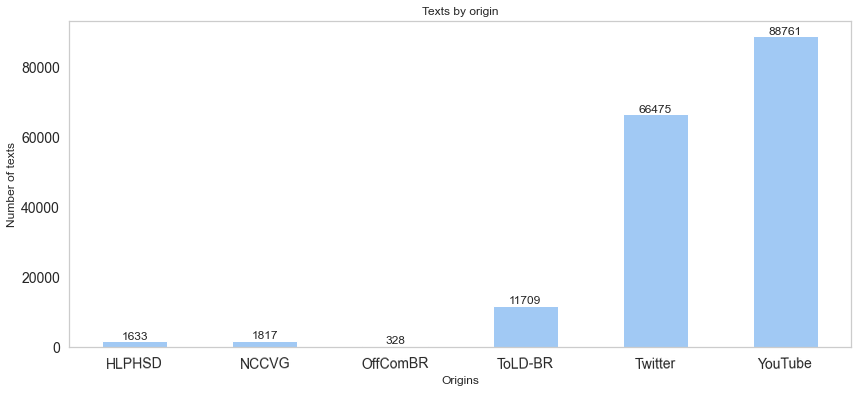

In [30]:
origins = [i["data"]["meta_info"]["source"] for i in new_data]

df_eda = pd.DataFrame(
    {"origin": origins,
    "i": 1}).groupby("origin").count()

ax = df_eda.plot(
    kind="bar", grid=False,
    legend=False, figsize=(14, 6),
    xlabel="Origins", ylabel="Number of texts", fontsize=14,
    rot=1, title="Texts by origin")

for container in ax.containers:
    ax.bar_label(container, fontsize=12)

In [54]:
olidbr_next_phase = train_test_split(
    new_data,
    stratify=origins,
    test_size=0.146436,
    random_state=seed)[1]

print(f"Total of {len(olidbr_next_phase)} comments for the next phase.")

Total of 25000 comments for the next phase.


## Check the origin distribution of the next phase data

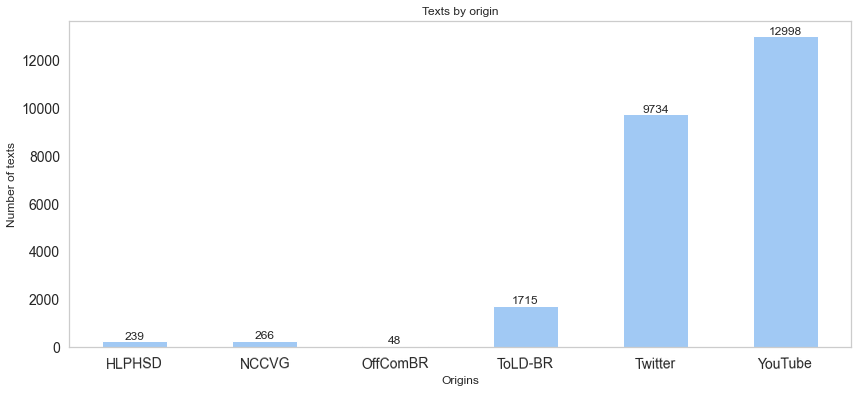

In [65]:
pilot_origins = [i["data"]["meta_info"]["source"] for i in olidbr_next_phase]

df_eda = pd.DataFrame(
    {"origin": pilot_origins,
    "i": 1}).groupby("origin").count()

ax = df_eda.plot(
    kind="bar", grid=False,
    legend=False, figsize=(14, 6),
    xlabel="Origins", ylabel="Number of texts", fontsize=14,
    rot=1, title="Texts by origin")

for container in ax.containers:
    ax.bar_label(container, fontsize=12)


## Upload to S3

To finish, we will upload the data to S3.

In [55]:
bucket.upload_json(
    data=new_data,
    key=f"raw/unlabeled/{datetime.datetime.now().date().isoformat()}-unlabeled.json")

print("Uploaded unlabeled data.")

Uploaded unlabeled data.


In [56]:
bucket.upload_json( 
    data=olidbr_next_phase,
    key="raw/unlabeled/olid-br-phase-4.json")

print("Uploaded OLID-BR next phase data.")

Uploaded OLID-BR next phase data.
